In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, transforms
import time
import os
import copy
import matplotlib.pyplot as plt

In [9]:
# Define custom CNN network
class CustomCNN(nn.Module):
    def __init__(self, num_classes=100):
        super(CustomCNN, self).__init__()

        # Convolutional layers with max pooling
        self.features = nn.Sequential(
            # First convolutional block
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Second convolutional block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Third convolutional block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [10]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data transformations
data_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

# Set dataset root directory
dataset_root = './data'

# Create dataset objects
trainset = datasets.CIFAR100(dataset_root, train=True, transform=data_transforms, download=True)
testset = datasets.CIFAR100(dataset_root, train=False, transform=test_transforms, download=True)

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)


Using device: cuda:0
Files already downloaded and verified
Files already downloaded and verified


In [11]:
# Initialize the model
model = CustomCNN(num_classes=100)
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

# Training parameters
num_epochs = 150
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())


In [12]:
# Lists to store metrics for plotting
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Train phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total += labels.size(0)

    # Calculate epoch metrics
    epoch_loss = running_loss / len(trainset)
    epoch_acc = running_corrects.double() / len(trainset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    # Validation phase
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    # Calculate epoch metrics
    epoch_loss = running_loss / len(testset)
    epoch_acc = running_corrects.double() / len(testset)
    test_losses.append(epoch_loss)
    test_accuracies.append(epoch_acc.item())

    print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    # Deep copy the model if it's the best one so far
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    # Step the scheduler
    scheduler.step()

    print()

print(f'Best val Acc: {best_acc:.4f}')


Epoch 1/150
----------
Train Loss: 4.6056 Acc: 0.0099
Val Loss: 4.6047 Acc: 0.0149

Epoch 2/150
----------
Train Loss: 4.5805 Acc: 0.0146
Val Loss: 4.4063 Acc: 0.0325

Epoch 3/150
----------
Train Loss: 4.2284 Acc: 0.0459
Val Loss: 3.9608 Acc: 0.0863

Epoch 4/150
----------
Train Loss: 3.9670 Acc: 0.0818
Val Loss: 3.7461 Acc: 0.1211

Epoch 5/150
----------
Train Loss: 3.7721 Acc: 0.1099
Val Loss: 3.4969 Acc: 0.1630

Epoch 6/150
----------
Train Loss: 3.6036 Acc: 0.1410
Val Loss: 3.3160 Acc: 0.1993

Epoch 7/150
----------
Train Loss: 3.4680 Acc: 0.1664
Val Loss: 3.1853 Acc: 0.2286

Epoch 8/150
----------
Train Loss: 3.3283 Acc: 0.1923
Val Loss: 3.0372 Acc: 0.2541

Epoch 9/150
----------
Train Loss: 3.2031 Acc: 0.2156
Val Loss: 2.8915 Acc: 0.2803

Epoch 10/150
----------
Train Loss: 3.0727 Acc: 0.2397
Val Loss: 2.7574 Acc: 0.3125

Epoch 11/150
----------
Train Loss: 2.9725 Acc: 0.2606
Val Loss: 2.6299 Acc: 0.3406

Epoch 12/150
----------
Train Loss: 2.8556 Acc: 0.2842
Val Loss: 2.5753 Ac

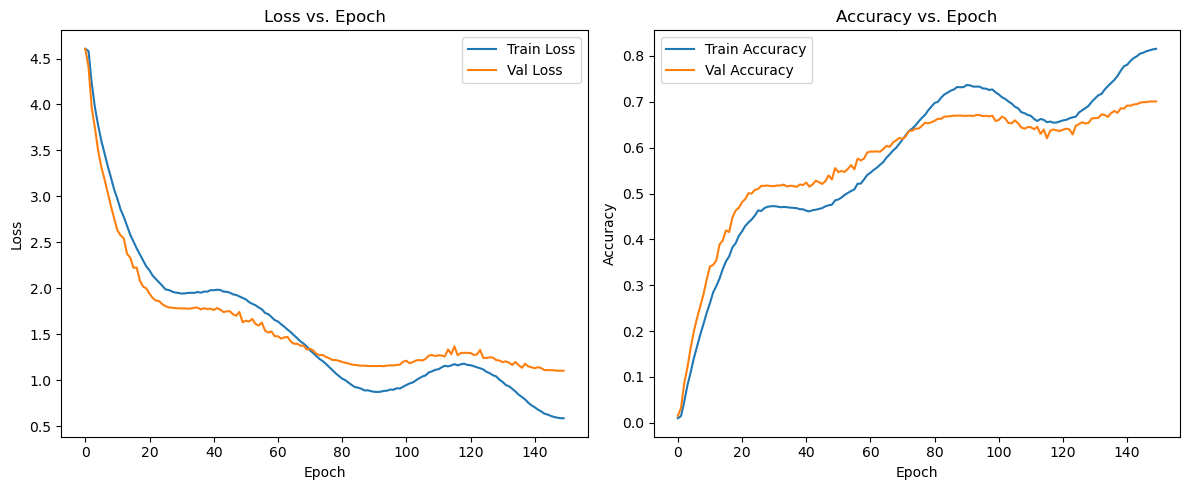

In [13]:
# Load best model weights
model.load_state_dict(best_model_wts)

# Save the best model
torch.save(model.state_dict(), 'best_model_custom_cnn.pth')

# Plot training and validation metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), test_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epoch')

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(num_epochs), test_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epoch')

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

In [14]:
# Test the best model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

Accuracy of the network on the 10000 test images: 70.09%
